# Contrastive Learning on CIFAR10 using Resnet Backbone

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


First, we import the dataset and define transformation operations on it. We apply random transformation on images (crop + flip + colorjitter + grayscale).

In [ ]:
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torch

class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            pos_1 = self.transform(img)
            pos_2 = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return pos_1, pos_2, target


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

We use commonly used ResNet-50 as ConvNet encoders for simplicity in the original paper. The task 1 is to set encoder and projection head. The parameters are adapted from the original paper.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet50


class Model(nn.Module):
    def __init__(self, feature_dim=128):
        super(Model, self).__init__()

        self.f = []
        for name, module in resnet50().named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # ----------------------------------------------------------------------
        # START OF YOUR CODE
        # ----------------------------------------------------------------------
        # Task 1
        # set a neural network base encoder self.f
        # hint: nn.Sequential
        # Reference : https://github.com/leftthomas/SimCLR/blob/master/model.py
        self.f = nn.Sequential(*self.f)


        # set a small neural network projection head
        # Dense-> Relu-> Dense (2-layer MLP to project the representation to a 128-dimensional latent space and 
        # the representation is 2048-dimensional here)
        # Reference : https://github.com/leftthomas/SimCLR/blob/master/model.py
        self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512),
                               nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))
     

        
        # ----------------------------------------------------------------------
        # END OF YOUR CODE
        # ----------------------------------------------------------------------
    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)


We train encoder network and projection head to maximize agreement using a contrastive loss. The default epoch is 1 for time efficiency while it could takes about 10 minutes to run for one epoch in google colab. The task 2 is to calculate the contrastive loss.
To evaluate the influence of temperature value for contrastive loss, we run this training process 3 times with different temperature value (0.1,0.5 and 1.0).

In [ ]:
import argparse
import os

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
!pip install thop
from thop import profile, clever_format
from torch.utils.data import DataLoader
from tqdm import tqdm


import math

def contrastive_loss(out_1, out_2, temperature):

    # ------------------------------------------------------------------
    # START OF YOUR CODE
    # ------------------------------------------------------------------
    # Task2: implement contrastive loss function and return loss variable
    # hint: loss formula could refer to the slides
    # input: out_1, out_2，temperature
    # output: loss variable

    out = torch.cat([out_1, out_2], dim=0)
    # [2*B, 2*B]
    sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
    # [2*B, 2*B-1]
    sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

    # compute loss
    pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    # [2*B]
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
    loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean() 

    # ------------------------------------------------------------------
    # END OF YOUR CODE
    # ------------------------------------------------------------------

    return loss

# train for one epoch to learn unique features
def train(net, data_loader, train_optimizer, train_scheduler, temperature):
    net.train()
    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for pos_1, pos_2, target in train_bar:
        pos_1, pos_2 = pos_1.cuda(non_blocking=True), pos_2.cuda(non_blocking=True)
        feature_1, out_1 = net(pos_1)
        feature_2, out_2 = net(pos_2)

        loss = contrastive_loss(out_1, out_2, temperature)

        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()
        train_scheduler.step()

        total_num += batch_size
        total_loss += loss.item() * batch_size
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_num))

    return total_loss / total_num


# test for one epoch, use weighted knn to find the most similar images' label to assign the test image
def test(net, memory_data_loader, test_data_loader, temperature):
    net.eval()
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, _, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature, out = net(data.cuda(non_blocking=True))
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, _, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature, out = net(data)

            total_num += data.size(0)
            # compute cos similarity between each feature vector and feature bank ---> [B, N]
            sim_matrix = torch.mm(feature, feature_bank)
            # [B, K]
            sim_weight, sim_indices = sim_matrix.topk(k=k, dim=-1)
            # [B, K]
            sim_labels = torch.gather(feature_labels.expand(data.size(0), -1), dim=-1, index=sim_indices)
            sim_weight = (sim_weight / temperature).exp()

            # counts for each class
            one_hot_label = torch.zeros(data.size(0) * k, c, device=sim_labels.device)
            # [B*K, C]
            one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
            # weighted score ---> [B, C]
            pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

            pred_labels = pred_scores.argsort(dim=-1, descending=True)
            total_top1 += torch.sum((pred_labels[:, :1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_top5 += torch.sum((pred_labels[:, :5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}% Acc@5:{:.2f}%'
                                     .format(epoch, epochs, total_top1 / total_num * 100, total_top5 / total_num * 100))

    return total_top1 / total_num * 100, total_top5 / total_num * 100

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Train SimCLR
import numpy as np
   
# Feature dim for latent vector, Temperature used in softmax, Top k most similar images used to predict the label
feature_dim, temp, k = 128, [0.1], 200
# Number of images in each mini-batch, Number of sweeps over the dataset to train
batch_size=128
#Coarse setting
#Fine setting
lr_start = 1.0e-6
lr_end =1000000.0
max_lrvalue=0.01875 #Rule of Thumb is peaklr (from lambdalr test)*3/8
min_lrvalue=0.001
temp0 = 0.1 #contrastive loss temperature setting
schedulertype='onecyclelr' #'lambdalr' for testing range of training or 'onecyclelr' for actual training
if schedulertype=='lambdalr':
    epochs=10
    str1=str(lr_start)
    str2=str(lr_end)
    str3='_'
    #epochs=10 #coarserg recommend 10 epochs, finerg recommend 100 epochs 
elif schedulertype=='onecyclelr':
    div_factorvalue=max_lrvalue/min_lrvalue
    epochs=500
    finaldiv_factorvalue=10000
    str1=str(max_lrvalue/div_factorvalue)
    str2=str(max_lrvalue)
    str3=str(max_lrvalue/div_factorvalue/finaldiv_factorvalue)
    #epochs=3
else:
    print('choose valid option for scheduler')
smoothfactor=0.95 #Smooth Factor for smoothing contrastive loss    
IterationStr='It1'
loadmodel=0 #loadmodel=0 From scratch or loadmodel=1 Continue from presaved model 
pathtosave='/content/gdrive/MyDrive/CS5260Project/results/Simclr_resnet50_RAdamv4'+schedulertype+'_minlr_'+str1+'_maxlr_'+str2+'_finallr_'+str3+'/'+IterationStr+'/'
save_name_pre = '{}_{}_{}_{}_{}'.format(feature_dim, temp0, k, batch_size, epochs)
csvfilename=pathtosave+'{}_statistics.csv'.format(save_name_pre)
modelfilename=pathtosave+'{}_model.pth'.format(save_name_pre)

# data prepare
train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True,
                          drop_last=True)
memory_data = CIFAR10Pair(root='data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_data = CIFAR10Pair(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

import torch
n=0
torch.cuda.is_available()
#torch.cuda.set_device(n)

# model setup and optimizer config
model = Model(feature_dim).cuda()

flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))

optimizer = optim.RAdam(model.parameters(), lr=1.0)
#optimizer=optim.Adam(model.parameters(),lr=1.0)

#exponentially increase learning rate from low to high
def lrs(batch):
   low = math.log2(lr_start)
   high = math.log2(lr_end)
   return 2**(low+(high-low)*batch/len(train_loader)/epochs)
   
if schedulertype=='lambdalr':
   scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lrs)
elif schedulertype=='onecyclelr':
   scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,div_factor=div_factorvalue,max_lr=max_lrvalue,final_div_factor=finaldiv_factorvalue,total_steps=len(train_loader)*epochs,epochs=epochs)
else:
   print('choose valid option for scheduler')

if loadmodel==1:
   checkpoint=torch.load(modelfilename)
   model.load_state_dict(checkpoint['model_state_dict'],strict=False)
   model.to(device)
   optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
   scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
   startepoch=checkpoint['epoch']+1
   best_acc=checkpoint['best_acc']

   print(startepoch)
else:     
   startepoch=1
   best_acc=0
   

c = len(memory_data.classes)

if not os.path.exists(pathtosave):
   os.makedirs(pathtosave)

train_loss_epoch=torch.zeros(epochs)
smooth_loss_epoch=torch.zeros(epochs)
test_acc_1_epoch=torch.zeros(epochs)
test_acc_5_epoch=torch.zeros(epochs)
lr_epoch=torch.zeros(epochs)

if loadmodel==1:

   df=pd.read_csv(csvfilename)
   temp=pd.to_numeric(df.iloc[0:startepoch-1,1]).apply(np.array)
   train_loss_epoch[0:temp.size]=torch.tensor(temp)
   train_loss_list=temp.tolist()
   temp=pd.to_numeric(df.iloc[0:startepoch-1,2]).apply(np.array)
   test_acc_1_epoch[0:temp.size]=torch.tensor(temp)
   test_acc_1_list=temp.tolist()
   temp=pd.to_numeric(df.iloc[0:startepoch-1,3]).apply(np.array)
   test_acc_5_epoch[0:temp.size]=torch.tensor(temp)
   test_acc_5_list=temp.tolist()
   temp=pd.to_numeric(df.iloc[0:startepoch-1,4]).apply(np.array)
   smooth_loss_epoch[0:temp.size]=torch.tensor(temp)
   smooth_loss_list=temp.tolist()
   temp=pd.to_numeric(df.iloc[0:startepoch-1,5]).apply(np.array)
   lr_epoch[0:temp.size]=torch.tensor(temp)
   lr_list=temp.tolist()
   results = {'train_loss': train_loss_list, 'test_acc@1': test_acc_1_list, 'test_acc@5': test_acc_5_list, 'smooth_loss': smooth_loss_list, 'lr_epoch': lr_list}

else:
   results = {'train_loss': [], 'test_acc@1': [], 'test_acc@5': [], 'smooth_loss': [], 'lr_epoch': []}


for epoch in range(startepoch, epochs + 1):
    train_loss = train(model, train_loader, optimizer, scheduler, temp0)
    train_loss_epoch[epoch-1]=train_loss
    if epoch>1:
       smooth_loss=float(train_loss_epoch[epoch-1]*smoothfactor+smooth_loss_epoch[epoch-2]*(1.0-smoothfactor))
    else:
       smooth_loss=train_loss
    smooth_loss_epoch[epoch-1]=torch.tensor(smooth_loss)


    print(optimizer.param_groups[0]['lr'])
    print(smooth_loss_epoch[epoch-1])
    lr_epoch[epoch-1]=float(optimizer.param_groups[0]['lr'])
   
        
    results['train_loss'].append(train_loss)
    test_acc_1, test_acc_5 = test(model, memory_loader, test_loader, temp0)
    results['test_acc@1'].append(test_acc_1)
    results['test_acc@5'].append(test_acc_5)
    results['smooth_loss'].append(smooth_loss)
    results['lr_epoch'].append(optimizer.param_groups[0]['lr'])
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
    data_frame.to_csv(csvfilename, index_label='epoch')
    if test_acc_1 > best_acc:
        best_acc = test_acc_1
        torch.save({'epoch':epoch,'model_state_dict':model.state_dict(),'optimizer_state_dict':optimizer.state_dict(),'scheduler_state_dict':scheduler.state_dict(),'best_acc':best_acc}, modelfilename)
    test_acc_1_epoch[epoch-1]=test_acc_1
    test_acc_5_epoch[epoch-1]=test_acc_5
    
minloss_loc=torch.argmin(smooth_loss_epoch)
minloss_lr=lr_epoch[minloss_loc]
maxgradloss_loc=torch.argmin(torch.gradient(smooth_loss_epoch)[0])
maxgradloss_lr=lr_epoch[maxgradloss_loc]
initfactor=1/10
maxfactor=1/10
print(f'lr corresponding to minloss={minloss_lr}');
print(f'lr corresponding to max grad={maxgradloss_lr}');
print(f'suggested maxlr={minloss_lr*maxfactor}');
print(f'suggested minlr={max(minloss_lr*initfactor*maxfactor,maxgradloss_lr)}');

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
Files already downloaded and verified
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[WARN] Cannot find rule for <class '__main__.Model'>. Treat it as zero Macs and zero Params.
# Model Params: 24.62M FLOPs: 1.31G


/usr/local/lib/python3.7/dist-packages/thop/vision/basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor(list((m.output_size,))).squeeze()
Train Epoch: [1/500] Loss: 4.9071: 100%|██████████| 390/390 [00:52<00:00,  7.48it/s]


0.0010019465007047798
tensor(4.9071)


Train Epoch: [2/500] Loss: 3.8087: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.0010077851489903797
tensor(3.8636)


Train Epoch: [3/500] Loss: 3.0861: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0010175133837451444
tensor(3.1250)


Train Epoch: [4/500] Loss: 2.6167: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.0010311269376979022
tensor(2.6421)


Train Epoch: [5/500] Loss: 2.2775: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0010486198392898084
tensor(2.2957)


Train Epoch: [6/500] Loss: 2.0617: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.0010699844152937676
tensor(2.0734)


Train Epoch: [7/500] Loss: 1.8883: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0010952112941802483
tensor(1.8975)


Train Epoch: [8/500] Loss: 1.7713: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.0011242894102281228
tensor(1.7776)


Train Epoch: [9/500] Loss: 1.6950: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0011572060083785973
tensor(1.6991)


Train Epoch: [10/500] Loss: 1.6419: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0011939466498302083
tensor(1.6448)


Train Epoch: [11/500] Loss: 1.5914: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0012344952183723744
tensor(1.5940)


Train Epoch: [12/500] Loss: 1.5269: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0012788339274547242
tensor(1.5303)


Train Epoch: [13/500] Loss: 1.5035: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0013269433279891503
tensor(1.5048)


Train Epoch: [14/500] Loss: 1.4523: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0013788023168811066
tensor(1.4549)


Train Epoch: [15/500] Loss: 1.4308: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0014343881462864465
tensor(1.4320)


Train Epoch: [16/500] Loss: 1.4007: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.0014936764335897017
tensor(1.4023)


Train Epoch: [17/500] Loss: 1.3698: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0015566411720994884
tensor(1.3715)


Train Epoch: [18/500] Loss: 1.3473: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.001623254742456285
tensor(1.3485)


Train Epoch: [19/500] Loss: 1.3284: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.0016934879247476053
tensor(1.3294)


Train Epoch: [20/500] Loss: 1.3052: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0017673099113252669
tensor(1.3064)


Train Epoch: [21/500] Loss: 1.2934: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0018446883203190878
tensor(1.2940)


Train Epoch: [22/500] Loss: 1.2761: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0019255892098411567
tensor(1.2770)


Train Epoch: [23/500] Loss: 1.2449: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.0020099770928743432
tensor(1.2465)


Train Epoch: [24/500] Loss: 1.2369: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.002097814952838648
tensor(1.2374)


Train Epoch: [25/500] Loss: 1.2145: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0021890642598284132
tensor(1.2157)


Train Epoch: [26/500] Loss: 1.2287: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.002283684987513416
tensor(1.2280)


Train Epoch: [27/500] Loss: 1.1921: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.002381635630696332
tensor(1.1939)


Train Epoch: [28/500] Loss: 1.1844: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.0024828732235189083
tensor(1.1849)


Train Epoch: [29/500] Loss: 1.1649: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0025873533583088623
tensor(1.1659)


Train Epoch: [30/500] Loss: 1.1471: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0026950302050592068
tensor(1.1480)


Train Epoch: [31/500] Loss: 1.1353: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.002805856531531495
tensor(1.1359)


Train Epoch: [32/500] Loss: 1.1251: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.002919783723974164
tensor(1.1257)


Train Epoch: [33/500] Loss: 1.1211: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.003036761808446836
tensor(1.1213)


Train Epoch: [34/500] Loss: 1.0887: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.003156739472741322
tensor(1.0904)


Train Epoch: [35/500] Loss: 1.0857: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0032796640888896004
tensor(1.0859)


Train Epoch: [36/500] Loss: 1.0768: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.003405481736248968
tensor(1.0772)


Train Epoch: [37/500] Loss: 1.0691: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.0035341372251542456
tensor(1.0696)


Train Epoch: [38/500] Loss: 1.0707: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.0036655741211265944
tensor(1.0707)


Train Epoch: [39/500] Loss: 1.0582: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.003799734769628405
tensor(1.0589)


Train Epoch: [40/500] Loss: 1.0327: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.003936560321353345
tensor(1.0340)


Train Epoch: [41/500] Loss: 1.0373: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.004075990758040484
tensor(1.0371)


Train Epoch: [42/500] Loss: 1.0180: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0042179649188011994
tensor(1.0189)


Train Epoch: [43/500] Loss: 0.9990: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.004362420526947264
tensor(1.0000)


Train Epoch: [44/500] Loss: 1.0070: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.004509294217308418
tensor(1.0067)


Train Epoch: [45/500] Loss: 1.0052: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.004658521564027348
tensor(1.0053)


Train Epoch: [46/500] Loss: 0.9851: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.004810037108819987
tensor(0.9861)


Train Epoch: [47/500] Loss: 0.9879: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.00496377438968865
tensor(0.9878)


Train Epoch: [48/500] Loss: 0.9714: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.00511966597007546
tensor(0.9722)


Train Epoch: [49/500] Loss: 0.9644: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.005277643468443274
tensor(0.9648)


Train Epoch: [50/500] Loss: 0.9607: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.005437637588271099
tensor(0.9609)


Train Epoch: [51/500] Loss: 0.9605: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.005599578148450874
tensor(0.9605)


Train Epoch: [52/500] Loss: 0.9536: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.005763394114072288
tensor(0.9539)


Train Epoch: [53/500] Loss: 0.9475: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.005929013627582087
tensor(0.9479)


Train Epoch: [54/500] Loss: 0.9403: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.006096364040304274
tensor(0.9407)


Train Epoch: [55/500] Loss: 0.9345: 100%|██████████| 390/390 [00:51<00:00,  7.50it/s]


0.006265371944307279
tensor(0.9348)


Train Epoch: [56/500] Loss: 0.9296: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.006435963204604234
tensor(0.9299)


Train Epoch: [57/500] Loss: 0.9251: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.006608062991672116
tensor(0.9253)


Train Epoch: [58/500] Loss: 0.9179: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.006781595814275586
tensor(0.9183)


Train Epoch: [59/500] Loss: 0.9162: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.006956485552581068
tensor(0.9163)


Train Epoch: [60/500] Loss: 0.9009: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.00713265549154656
tensor(0.9017)


Train Epoch: [61/500] Loss: 0.8929: 100%|██████████| 390/390 [00:52<00:00,  7.50it/s]


0.0073100283545725515
tensor(0.8934)


Train Epoch: [62/500] Loss: 0.8844: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.007488526337399231
tensor(0.8848)


Train Epoch: [63/500] Loss: 0.8897: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.007668071142235189
tensor(0.8895)


Train Epoch: [64/500] Loss: 0.8882: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.007848584012102594
tensor(0.8883)


Train Epoch: [65/500] Loss: 0.8803: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.00802998576538377
tensor(0.8807)


Train Epoch: [66/500] Loss: 0.8759: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.008212196830554073
tensor(0.8762)


Train Epoch: [67/500] Loss: 0.8668: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.008395137281085782
tensor(0.8673)


Train Epoch: [68/500] Loss: 0.8647: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.00857872687050771
tensor(0.8648)


Train Epoch: [69/500] Loss: 0.8592: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.00876288506760516
tensor(0.8595)


Train Epoch: [70/500] Loss: 0.8561: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.008947531091744797
tensor(0.8562)


Train Epoch: [71/500] Loss: 0.8548: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.009132583948308905
tensor(0.8549)


Train Epoch: [72/500] Loss: 0.8493: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.009317962464223511
tensor(0.8495)


Train Epoch: [73/500] Loss: 0.8478: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.00950358532356482
tensor(0.8479)


Train Epoch: [74/500] Loss: 0.8352: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.009689371103228258
tensor(0.8358)


Train Epoch: [75/500] Loss: 0.8385: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.00987523830864457
tensor(0.8384)


Train Epoch: [76/500] Loss: 0.8354: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.01006110540952726
tensor(0.8355)


Train Epoch: [77/500] Loss: 0.8215: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.010246890875635685
tensor(0.8222)


Train Epoch: [78/500] Loss: 0.8255: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.010432513212538134
tensor(0.8254)


Train Epoch: [79/500] Loss: 0.8174: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.0106178909973592
tensor(0.8178)


Train Epoch: [80/500] Loss: 0.8137: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.010802942914495775
tensor(0.8139)


Train Epoch: [81/500] Loss: 0.8066: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.010987587791285969
tensor(0.8069)


Train Epoch: [82/500] Loss: 0.8114: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01117174463361535
tensor(0.8111)


Train Epoch: [83/500] Loss: 0.8172: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.011355332661444843
tensor(0.8169)


Train Epoch: [84/500] Loss: 0.7999: 100%|██████████| 390/390 [00:52<00:00,  7.50it/s]


0.011538271344244748
tensor(0.8008)


Train Epoch: [85/500] Loss: 0.7884: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.011720480436319286
tensor(0.7890)


Train Epoch: [86/500] Loss: 0.7990: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.011901880012006226
tensor(0.7985)


Train Epoch: [87/500] Loss: 0.7956: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.012082390500736132
tensor(0.7957)


Train Epoch: [88/500] Loss: 0.7866: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.012261932721935802
tensor(0.7870)


Train Epoch: [89/500] Loss: 0.7942: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.012440427919760712
tensor(0.7938)


Train Epoch: [90/500] Loss: 0.7922: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.012617797797641089
tensor(0.7923)


Train Epoch: [91/500] Loss: 0.7778: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.012793964552626548
tensor(0.7785)


Train Epoch: [92/500] Loss: 0.7703: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01296885090951423
tensor(0.7707)


Train Epoch: [93/500] Loss: 0.7723: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.013142380154745382
tensor(0.7723)


Train Epoch: [94/500] Loss: 0.7834: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.013314476170055638
tensor(0.7829)


Train Epoch: [95/500] Loss: 0.7699: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.013485063465864124
tensor(0.7705)


Train Epoch: [96/500] Loss: 0.7657: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.013654067214386846
tensor(0.7660)


Train Epoch: [97/500] Loss: 0.7684: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01382141328245972
tensor(0.7682)


Train Epoch: [98/500] Loss: 0.7581: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01398702826405695
tensor(0.7586)


Train Epoch: [99/500] Loss: 0.7529: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.014150839512490455
tensor(0.7531)


Train Epoch: [100/500] Loss: 0.7489: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.014312775172276162
tensor(0.7491)


Train Epoch: [101/500] Loss: 0.7411: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.014472764210653312
tensor(0.7415)


Train Epoch: [102/500] Loss: 0.7419: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.014630736448742816
tensor(0.7418)


Train Epoch: [103/500] Loss: 0.7339: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.01478662259233109
tensor(0.7343)


Train Epoch: [104/500] Loss: 0.7443: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.014940354262265821
tensor(0.7438)


Train Epoch: [105/500] Loss: 0.7321: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.015091864024450367
tensor(0.7327)


Train Epoch: [106/500] Loss: 0.7410: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.015241085419423577
tensor(0.7406)


Train Epoch: [107/500] Loss: 0.7311: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.015387952991512095
tensor(0.7316)


Train Epoch: [108/500] Loss: 0.7244: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.015532402317542389
tensor(0.7247)


Train Epoch: [109/500] Loss: 0.7307: 100%|██████████| 390/390 [00:52<00:00,  7.50it/s]


0.015674370035099822
tensor(0.7304)


Train Epoch: [110/500] Loss: 0.7191: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.015813793870322473
tensor(0.7196)


Train Epoch: [111/500] Loss: 0.7137: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.01595061266521744
tensor(0.7140)


Train Epoch: [112/500] Loss: 0.7219: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.016084766404487662
tensor(0.7215)


Train Epoch: [113/500] Loss: 0.6998: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01621619624185753
tensor(0.7009)


Train Epoch: [114/500] Loss: 0.7069: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.01634484452588567
tensor(0.7066)


Train Epoch: [115/500] Loss: 0.7206: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01647065482525365
tensor(0.7199)


Train Epoch: [116/500] Loss: 0.7095: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.016593571953519473
tensor(0.7100)


Train Epoch: [117/500] Loss: 0.7114: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01671354199332499
tensor(0.7113)


Train Epoch: [118/500] Loss: 0.6978: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.016830512320046637
tensor(0.6984)


Train Epoch: [119/500] Loss: 0.7068: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.016944431624879148
tensor(0.7064)


Train Epoch: [120/500] Loss: 0.7018: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.017055249937342032
tensor(0.7020)


Train Epoch: [121/500] Loss: 0.6934: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.017162918647199054
tensor(0.6938)


Train Epoch: [122/500] Loss: 0.7005: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.017267390525781003
tensor(0.7002)


Train Epoch: [123/500] Loss: 0.6904: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.017368619746702462
tensor(0.6909)


Train Epoch: [124/500] Loss: 0.6868: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.017466561905963462
tensor(0.6870)


Train Epoch: [125/500] Loss: 0.6844: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.017561174041427204
tensor(0.6845)


Train Epoch: [126/500] Loss: 0.6864: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01765241465166533
tensor(0.6864)


Train Epoch: [127/500] Loss: 0.6852: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.017740243714162426
tensor(0.6853)


Train Epoch: [128/500] Loss: 0.6795: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.01782462270287184
tensor(0.6798)


Train Epoch: [129/500] Loss: 0.6772: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.017905514605115025
tensor(0.6773)


Train Epoch: [130/500] Loss: 0.6835: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.01798288393781712
tensor(0.6832)


Train Epoch: [131/500] Loss: 0.6731: 100%|██████████| 390/390 [00:52<00:00,  7.50it/s]


0.018056696763071513
tensor(0.6736)


Train Epoch: [132/500] Loss: 0.6675: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.01812692070302661
tensor(0.6678)


Train Epoch: [133/500] Loss: 0.6587: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.018193524954088366
tensor(0.6591)


Train Epoch: [134/500] Loss: 0.6637: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018256480300432185
tensor(0.6635)


Train Epoch: [135/500] Loss: 0.6641: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018315759126818397
tensor(0.6641)


Train Epoch: [136/500] Loss: 0.6551: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.018371335430705637
tensor(0.6555)


Train Epoch: [137/500] Loss: 0.6620: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018423184833656785
tensor(0.6616)


Train Epoch: [138/500] Loss: 0.6544: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.018471284592032546
tensor(0.6548)


Train Epoch: [139/500] Loss: 0.6598: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018515613606967886
tensor(0.6596)


Train Epoch: [140/500] Loss: 0.6456: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.01855615243362702
tensor(0.6463)


Train Epoch: [141/500] Loss: 0.6532: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.01859288328973284
tensor(0.6529)


Train Epoch: [142/500] Loss: 0.6441: 100%|██████████| 390/390 [00:51<00:00,  7.50it/s]


0.018625790063367075
tensor(0.6446)


Train Epoch: [143/500] Loss: 0.6442: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.018654858320037774
tensor(0.6442)


Train Epoch: [144/500] Loss: 0.6491: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018680075309010943
tensor(0.6489)


Train Epoch: [145/500] Loss: 0.6337: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.018701429968903633
tensor(0.6345)


Train Epoch: [146/500] Loss: 0.6327: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.01871891293253601
tensor(0.6328)


Train Epoch: [147/500] Loss: 0.6467: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018732516531040237
tensor(0.6460)


Train Epoch: [148/500] Loss: 0.6302: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.018742234797224408
tensor(0.6310)


Train Epoch: [149/500] Loss: 0.6324: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.018748063468190045
tensor(0.6323)


Train Epoch: [150/500] Loss: 0.6290: 100%|██████████| 390/390 [00:52<00:00,  7.49it/s]


0.01874999999751702
tensor(0.6292)


Train Epoch: [151/500] Loss: 0.6244: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018749620401934005
tensor(0.6246)


Train Epoch: [152/500] Loss: 0.6297: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.018748485519166535
tensor(0.6294)


Train Epoch: [153/500] Loss: 0.6203: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.018746595440649456
tensor(0.6208)


Train Epoch: [154/500] Loss: 0.6282: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018743950318661964
tensor(0.6278)


Train Epoch: [155/500] Loss: 0.6266: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01874055036631535
tensor(0.6266)


Train Epoch: [156/500] Loss: 0.6222: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.01873639585753581
tensor(0.6224)


Train Epoch: [157/500] Loss: 0.6205: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.01873148712704238
tensor(0.6206)


Train Epoch: [158/500] Loss: 0.6229: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.018725824570319998
tensor(0.6228)


Train Epoch: [159/500] Loss: 0.6060: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018719408643587582
tensor(0.6068)


Train Epoch: [160/500] Loss: 0.6000: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.018712239863761335
tensor(0.6003)


Train Epoch: [161/500] Loss: 0.6026: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018704318808413053
tensor(0.6025)


Train Epoch: [162/500] Loss: 0.6111: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.018695646115723625
tensor(0.6106)


Train Epoch: [163/500] Loss: 0.6085: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018686222484431584
tensor(0.6086)


Train Epoch: [164/500] Loss: 0.6130: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018676048673776837
tensor(0.6128)


Train Epoch: [165/500] Loss: 0.6020: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018665125503439482
tensor(0.6025)


Train Epoch: [166/500] Loss: 0.5989: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018653453853473778
tensor(0.5991)


Train Epoch: [167/500] Loss: 0.5962: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018641034664237235
tensor(0.5963)


Train Epoch: [168/500] Loss: 0.5918: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018627868936314837
tensor(0.5921)


Train Epoch: [169/500] Loss: 0.5908: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.018613957730438457
tensor(0.5909)


Train Epoch: [170/500] Loss: 0.5971: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.01859930216740138
tensor(0.5968)


Train Epoch: [171/500] Loss: 0.5810: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.01858390342796799
tensor(0.5817)


Train Epoch: [172/500] Loss: 0.5920: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.018567762752778674
tensor(0.5915)


Train Epoch: [173/500] Loss: 0.5787: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.01855088144224983
tensor(0.5793)


Train Epoch: [174/500] Loss: 0.5827: 100%|██████████| 390/390 [00:52<00:00,  7.48it/s]


0.018533260856469114
tensor(0.5825)


Train Epoch: [175/500] Loss: 0.5823: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.018514902415085858
tensor(0.5823)


Train Epoch: [176/500] Loss: 0.5772: 100%|██████████| 390/390 [00:51<00:00,  7.50it/s]


0.0184958075971967
tensor(0.5775)


Train Epoch: [177/500] Loss: 0.5757: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.0184759779412264
tensor(0.5758)


Train Epoch: [178/500] Loss: 0.5755: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.0184554150448039
tensor(0.5755)


Train Epoch: [179/500] Loss: 0.5843: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018434120564633616
tensor(0.5838)


Train Epoch: [180/500] Loss: 0.5802: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.018412096216361945
tensor(0.5804)


Train Epoch: [181/500] Loss: 0.5662: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018389343774439057
tensor(0.5669)


Train Epoch: [182/500] Loss: 0.5651: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018365865071975913
tensor(0.5651)


Train Epoch: [183/500] Loss: 0.5670: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018341662000596594
tensor(0.5670)


Train Epoch: [184/500] Loss: 0.5761: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01831673651028588
tensor(0.5757)


Train Epoch: [185/500] Loss: 0.5686: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.018291090609232154
tensor(0.5689)


Train Epoch: [186/500] Loss: 0.5604: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.01826472636366561
tensor(0.5609)


Train Epoch: [187/500] Loss: 0.5565: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.01823764589769178
tensor(0.5567)


Train Epoch: [188/500] Loss: 0.5662: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018209851393120386
tensor(0.5658)


Train Epoch: [189/500] Loss: 0.5570: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.018181345089289577
tensor(0.5574)


Train Epoch: [190/500] Loss: 0.5652: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.018152129282885492
tensor(0.5648)


Train Epoch: [191/500] Loss: 0.5663: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018122206327757247
tensor(0.5662)


Train Epoch: [192/500] Loss: 0.5572: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.018091578634727257
tensor(0.5577)


Train Epoch: [193/500] Loss: 0.5607: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.018060248671397033
tensor(0.5605)


Train Epoch: [194/500] Loss: 0.5527: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01802821896194835
tensor(0.5531)


Train Epoch: [195/500] Loss: 0.5541: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01799549208693989
tensor(0.5540)


Train Epoch: [196/500] Loss: 0.5471: 100%|██████████| 390/390 [00:52<00:00,  7.49it/s]


0.017962070683099345
tensor(0.5475)


Train Epoch: [197/500] Loss: 0.5422: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.017927957443110945
tensor(0.5425)


Train Epoch: [198/500] Loss: 0.5492: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01789315511539856
tensor(0.5489)


Train Epoch: [199/500] Loss: 0.5473: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.017857666503904236
tensor(0.5474)


Train Epoch: [200/500] Loss: 0.5395: 100%|██████████| 390/390 [00:51<00:00,  7.50it/s]


0.01782149446786229
tensor(0.5399)


Train Epoch: [201/500] Loss: 0.5452: 100%|██████████| 390/390 [00:52<00:00,  7.50it/s]


0.017784641921568967
tensor(0.5449)


Train Epoch: [202/500] Loss: 0.5470: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01774711183414762
tensor(0.5469)


Train Epoch: [203/500] Loss: 0.5427: 100%|██████████| 390/390 [00:52<00:00,  7.49it/s]


0.0177089072293095
tensor(0.5429)


Train Epoch: [204/500] Loss: 0.5383: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.017670031185110166
tensor(0.5386)


Train Epoch: [205/500] Loss: 0.5366: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.017630486833701452
tensor(0.5367)


Train Epoch: [206/500] Loss: 0.5421: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.017590277361079154
tensor(0.5418)


Train Epoch: [207/500] Loss: 0.5428: 100%|██████████| 390/390 [00:52<00:00,  7.45it/s]


0.017549406006826317
tensor(0.5428)


Train Epoch: [208/500] Loss: 0.5376: 100%|██████████| 390/390 [00:51<00:00,  7.50it/s]


0.017507876063852245
tensor(0.5378)


Train Epoch: [209/500] Loss: 0.5291: 100%|██████████| 390/390 [00:51<00:00,  7.50it/s]


0.01746569087812719
tensor(0.5296)


Train Epoch: [210/500] Loss: 0.5334: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01742285384841278
tensor(0.5332)


Train Epoch: [211/500] Loss: 0.5339: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.017379368425988185
tensor(0.5338)


Train Epoch: [212/500] Loss: 0.5320: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01733523811437206
tensor(0.5321)


Train Epoch: [213/500] Loss: 0.5265: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.017290466469040266
tensor(0.5268)


Train Epoch: [214/500] Loss: 0.5287: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01724505709713943
tensor(0.5286)


Train Epoch: [215/500] Loss: 0.5332: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.0171990136571963
tensor(0.5329)


Train Epoch: [216/500] Loss: 0.5258: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01715233985882302
tensor(0.5262)


Train Epoch: [217/500] Loss: 0.5205: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.01710503946241822
tensor(0.5208)


Train Epoch: [218/500] Loss: 0.5252: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.01705711627886408
tensor(0.5249)


Train Epoch: [219/500] Loss: 0.5170: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.017008574169219262
tensor(0.5174)


Train Epoch: [220/500] Loss: 0.5194: 100%|██████████| 390/390 [00:52<00:00,  7.49it/s]


0.01695941704440788
tensor(0.5193)


Train Epoch: [221/500] Loss: 0.5219: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.016909648864904366
tensor(0.5218)


Train Epoch: [222/500] Loss: 0.5240: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.016859273640414393
tensor(0.5239)


Train Epoch: [223/500] Loss: 0.5219: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.016808295429551832
tensor(0.5220)


Train Epoch: [224/500] Loss: 0.5111: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.01675671833951176
tensor(0.5117)


Train Epoch: [225/500] Loss: 0.5130: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.016704546525739536
tensor(0.5129)


Train Epoch: [226/500] Loss: 0.5179: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.016651784191596023
tensor(0.5177)


Train Epoch: [227/500] Loss: 0.5101: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.016598435588018934
tensor(0.5105)


Train Epoch: [228/500] Loss: 0.5140: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.01654450501318032
tensor(0.5138)


Train Epoch: [229/500] Loss: 0.5151: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01648999681214031
tensor(0.5150)


Train Epoch: [230/500] Loss: 0.5107: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01643491537649702
tensor(0.5110)


Train Epoch: [231/500] Loss: 0.5084: 100%|██████████| 390/390 [00:51<00:00,  7.50it/s]


0.016379265144032727
tensor(0.5085)


Train Epoch: [232/500] Loss: 0.5145: 100%|██████████| 390/390 [00:52<00:00,  7.49it/s]


0.016323050598356346
tensor(0.5142)


Train Epoch: [233/500] Loss: 0.5046: 100%|██████████| 390/390 [00:51<00:00,  7.50it/s]


0.01626627626854218
tensor(0.5051)


Train Epoch: [234/500] Loss: 0.5136: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01620894672876504
tensor(0.5132)


Train Epoch: [235/500] Loss: 0.4998: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.01615106659793168
tensor(0.5004)


Train Epoch: [236/500] Loss: 0.5036: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.016092640539308714
tensor(0.5034)


Train Epoch: [237/500] Loss: 0.5024: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.016033673260146857
tensor(0.5024)


Train Epoch: [238/500] Loss: 0.5095: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.015974169511301713
tensor(0.5091)


Train Epoch: [239/500] Loss: 0.4988: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.015914134086850978
tensor(0.4994)


Train Epoch: [240/500] Loss: 0.5023: 100%|██████████| 390/390 [00:52<00:00,  7.49it/s]


0.015853571823708213
tensor(0.5022)


Train Epoch: [241/500] Loss: 0.4976: 100%|██████████| 390/390 [00:52<00:00,  7.50it/s]


0.015792487601233144
tensor(0.4978)


Train Epoch: [242/500] Loss: 0.4962: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.015730886340838527
tensor(0.4962)


Train Epoch: [243/500] Loss: 0.4960: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.015668773005593658
tensor(0.4960)


Train Epoch: [244/500] Loss: 0.4976: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.015606152599824504
tensor(0.4976)


Train Epoch: [245/500] Loss: 0.4994: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.01554303016871052
tensor(0.4993)


Train Epoch: [246/500] Loss: 0.4969: 100%|██████████| 390/390 [00:52<00:00,  7.50it/s]


0.015479410797878162
tensor(0.4970)


Train Epoch: [247/500] Loss: 0.4904: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.015415299612991156
tensor(0.4907)


Train Epoch: [248/500] Loss: 0.4950: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.015350701779337542
tensor(0.4948)


Train Epoch: [249/500] Loss: 0.4903: 100%|██████████| 390/390 [00:52<00:00,  7.48it/s]


0.015285622501413501
tensor(0.4905)


Train Epoch: [250/500] Loss: 0.4889: 100%|██████████| 390/390 [00:52<00:00,  7.47it/s]


0.015220067022504058
tensor(0.4889)


Train Epoch: [251/500] Loss: 0.4879: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.015154040624260639
tensor(0.4880)


Train Epoch: [252/500] Loss: 0.4819: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.015087548626275525
tensor(0.4822)


Train Epoch: [253/500] Loss: 0.4791: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01502059638565329
tensor(0.4793)


Train Epoch: [254/500] Loss: 0.4904: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.014953189296579182
tensor(0.4899)


Train Epoch: [255/500] Loss: 0.4874: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.014885332789884511
tensor(0.4875)


Train Epoch: [256/500] Loss: 0.4810: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01481703233260912
tensor(0.4813)


Train Epoch: [257/500] Loss: 0.4855: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.01474829342756091
tensor(0.4853)


Train Epoch: [258/500] Loss: 0.4794: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.014679121612872492
tensor(0.4797)


Train Epoch: [259/500] Loss: 0.4838: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.014609522461554992
tensor(0.4836)


Train Epoch: [260/500] Loss: 0.4813: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.014539501581049052
tensor(0.4814)


Train Epoch: [261/500] Loss: 0.4810: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.014469064612773041
tensor(0.4811)


Train Epoch: [262/500] Loss: 0.4814: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.01439821723166855
tensor(0.4814)


Train Epoch: [263/500] Loss: 0.4747: 100%|██████████| 390/390 [00:52<00:00,  7.49it/s]


0.014326965145743163
tensor(0.4750)


Train Epoch: [264/500] Loss: 0.4806: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.014255314095610592
tensor(0.4803)


Train Epoch: [265/500] Loss: 0.4816: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.01418326985402816
tensor(0.4816)


Train Epoch: [266/500] Loss: 0.4733: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.0141108382254317
tensor(0.4737)


Train Epoch: [267/500] Loss: 0.4703: 100%|██████████| 390/390 [00:52<00:00,  7.48it/s]


0.014038025045467912
tensor(0.4705)


Train Epoch: [268/500] Loss: 0.4758: 100%|██████████| 390/390 [00:52<00:00,  7.47it/s]


0.013964836180524194
tensor(0.4756)


Train Epoch: [269/500] Loss: 0.4716: 100%|██████████| 390/390 [00:51<00:00,  7.50it/s]


0.01389127752725601
tensor(0.4718)


Train Epoch: [270/500] Loss: 0.4754: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.013817355012111794
tensor(0.4752)


Train Epoch: [271/500] Loss: 0.4675: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.013743074590855487
tensor(0.4678)


Train Epoch: [272/500] Loss: 0.4671: 100%|██████████| 390/390 [00:52<00:00,  7.49it/s]


0.01366844224808668
tensor(0.4671)


Train Epoch: [273/500] Loss: 0.4634: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.013593463996758464
tensor(0.4636)


Train Epoch: [274/500] Loss: 0.4694: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.013518145877692967
tensor(0.4691)


Train Epoch: [275/500] Loss: 0.4659: 100%|██████████| 390/390 [00:51<00:00,  7.51it/s]


0.013442493959094666
tensor(0.4661)


Train Epoch: [276/500] Loss: 0.4685: 100%|██████████| 390/390 [00:52<00:00,  7.50it/s]


0.013366514336061489
tensor(0.4684)


Train Epoch: [277/500] Loss: 0.4666: 100%|██████████| 390/390 [00:52<00:00,  7.48it/s]


0.013290213130093733
tensor(0.4667)


Train Epoch: [278/500] Loss: 0.4640: 100%|██████████| 390/390 [00:52<00:00,  7.48it/s]


0.013213596488600888
tensor(0.4641)


Train Epoch: [279/500] Loss: 0.4669: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.013136670584406348
tensor(0.4668)


Train Epoch: [280/500] Loss: 0.4678: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.013059441615250059
tensor(0.4677)


Train Epoch: [281/500] Loss: 0.4585: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.01298191580328923
tensor(0.4590)


Train Epoch: [282/500] Loss: 0.4567: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.01290409939459698
tensor(0.4568)


Train Epoch: [283/500] Loss: 0.4576: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.012825998658659129
tensor(0.4575)


Train Epoch: [284/500] Loss: 0.4561: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.012747619887869086
tensor(0.4562)


Train Epoch: [285/500] Loss: 0.4613: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.012668969397020863
tensor(0.4611)


Train Epoch: [286/500] Loss: 0.4508: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.012590053522800335
tensor(0.4513)


Train Epoch: [287/500] Loss: 0.4493: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.01251087862327468
tensor(0.4494)


Train Epoch: [288/500] Loss: 0.4564: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.012431451077380154
tensor(0.4561)


Train Epoch: [289/500] Loss: 0.4531: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.012351777284408125
tensor(0.4533)


Train Epoch: [290/500] Loss: 0.4591: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.012271863663489518
tensor(0.4588)


Train Epoch: [291/500] Loss: 0.4542: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.012191716653077637
tensor(0.4544)


Train Epoch: [292/500] Loss: 0.4470: 100%|██████████| 390/390 [00:51<00:00,  7.61it/s]


0.012111342710429424
tensor(0.4474)


Train Epoch: [293/500] Loss: 0.4513: 100%|██████████| 390/390 [00:51<00:00,  7.61it/s]


0.012030748311085224
tensor(0.4511)


Train Epoch: [294/500] Loss: 0.4577: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.011949939948347059
tensor(0.4574)


Train Epoch: [295/500] Loss: 0.4510: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.011868924132755485
tensor(0.4513)


Train Epoch: [296/500] Loss: 0.4443: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.01178770739156505
tensor(0.4446)


Train Epoch: [297/500] Loss: 0.4422: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.011706296268218393
tensor(0.4423)


Train Epoch: [298/500] Loss: 0.4446: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.011624697321819082
tensor(0.4445)


Train Epoch: [299/500] Loss: 0.4484: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.011542917126603148
tensor(0.4482)


Train Epoch: [300/500] Loss: 0.4356: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.01146096227140941
tensor(0.4363)


Train Epoch: [301/500] Loss: 0.4469: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.011378839359148636
tensor(0.4464)


Train Epoch: [302/500] Loss: 0.4429: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.011296555006271549
tensor(0.4431)


Train Epoch: [303/500] Loss: 0.4415: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.01121411584223578
tensor(0.4416)


Train Epoch: [304/500] Loss: 0.4429: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.011131528508971715
tensor(0.4428)


Train Epoch: [305/500] Loss: 0.4393: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.011048799660347407
tensor(0.4394)


Train Epoch: [306/500] Loss: 0.4347: 100%|██████████| 390/390 [00:51<00:00,  7.61it/s]


0.010965935961632452
tensor(0.4349)


Train Epoch: [307/500] Loss: 0.4371: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.010882944088961016
tensor(0.4370)


Train Epoch: [308/500] Loss: 0.4381: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.010799830728793928
tensor(0.4381)


Train Epoch: [309/500] Loss: 0.4396: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.010716602577379993
tensor(0.4395)


Train Epoch: [310/500] Loss: 0.4378: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.01063326634021647
tensor(0.4378)


Train Epoch: [311/500] Loss: 0.4328: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.01054982873150883
tensor(0.4330)


Train Epoch: [312/500] Loss: 0.4362: 100%|██████████| 390/390 [00:51<00:00,  7.62it/s]


0.010466296473629825
tensor(0.4361)


Train Epoch: [313/500] Loss: 0.4327: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.010382676296577853
tensor(0.4329)


Train Epoch: [314/500] Loss: 0.4313: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.010298974937434771
tensor(0.4313)


Train Epoch: [315/500] Loss: 0.4379: 100%|██████████| 390/390 [00:51<00:00,  7.61it/s]


0.010215199139823074
tensor(0.4375)


Train Epoch: [316/500] Loss: 0.4300: 100%|██████████| 390/390 [00:51<00:00,  7.62it/s]


0.01013135565336259
tensor(0.4304)


Train Epoch: [317/500] Loss: 0.4235: 100%|██████████| 390/390 [00:51<00:00,  7.61it/s]


0.010047451233126692
tensor(0.4239)


Train Epoch: [318/500] Loss: 0.4293: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.009963492639098029
tensor(0.4291)


Train Epoch: [319/500] Loss: 0.4316: 100%|██████████| 390/390 [00:51<00:00,  7.61it/s]


0.009879486635623914
tensor(0.4314)


Train Epoch: [320/500] Loss: 0.4339: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.009795439990871332
tensor(0.4338)


Train Epoch: [321/500] Loss: 0.4280: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.009711359476281625
tensor(0.4283)


Train Epoch: [322/500] Loss: 0.4287: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.009627251866024965
tensor(0.4287)


Train Epoch: [323/500] Loss: 0.4258: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.009543123936454553
tensor(0.4259)


Train Epoch: [324/500] Loss: 0.4215: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.009458982465560666
tensor(0.4217)


Train Epoch: [325/500] Loss: 0.4229: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.009374834232424578
tensor(0.4229)


Train Epoch: [326/500] Loss: 0.4190: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.009290686016672375
tensor(0.4192)


Train Epoch: [327/500] Loss: 0.4157: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.009206544597928757
tensor(0.4159)


Train Epoch: [328/500] Loss: 0.4168: 100%|██████████| 390/390 [00:51<00:00,  7.61it/s]


0.00912241675527078
tensor(0.4168)


Train Epoch: [329/500] Loss: 0.4250: 100%|██████████| 390/390 [00:51<00:00,  7.61it/s]


0.009038309266681732
tensor(0.4246)


Train Epoch: [330/500] Loss: 0.4256: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.008954228908505007
tensor(0.4255)


Train Epoch: [331/500] Loss: 0.4166: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.00887018245489817
tensor(0.4171)


Train Epoch: [332/500] Loss: 0.4161: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.008786176677287172
tensor(0.4161)


Train Epoch: [333/500] Loss: 0.4188: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.008702218343820792
tensor(0.4187)


Train Epoch: [334/500] Loss: 0.4152: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.008618314218825359
tensor(0.4154)


Train Epoch: [335/500] Loss: 0.4143: 100%|██████████| 390/390 [00:51<00:00,  7.62it/s]


0.00853447106225973
tensor(0.4144)


Train Epoch: [336/500] Loss: 0.4146: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.008450695629170696
tensor(0.4146)


Train Epoch: [337/500] Loss: 0.4207: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.008366994669148723
tensor(0.4204)


Train Epoch: [338/500] Loss: 0.4147: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.008283374925784149
tensor(0.4149)


Train Epoch: [339/500] Loss: 0.4131: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.008199843136123883
tensor(0.4132)


Train Epoch: [340/500] Loss: 0.4185: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.008116406030128608
tensor(0.4182)


Train Epoch: [341/500] Loss: 0.4173: 100%|██████████| 390/390 [00:51<00:00,  7.61it/s]


0.008033070330130567
tensor(0.4173)


Train Epoch: [342/500] Loss: 0.4091: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.007949842750291954
tensor(0.4095)


Train Epoch: [343/500] Loss: 0.4021: 100%|██████████| 390/390 [00:51<00:00,  7.61it/s]


0.007866729996063986
tensor(0.4025)


Train Epoch: [344/500] Loss: 0.4128: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0077837387636466365
tensor(0.4123)


Train Epoch: [345/500] Loss: 0.4089: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.007700875739449157
tensor(0.4090)


Train Epoch: [346/500] Loss: 0.4151: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.0076181475995513665
tensor(0.4148)


Train Epoch: [347/500] Loss: 0.4053: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.00753556100916577
tensor(0.4058)


Train Epoch: [348/500] Loss: 0.4086: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.007453122622100555
tensor(0.4085)


Train Epoch: [349/500] Loss: 0.4097: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.007370839080223518
tensor(0.4097)


Train Epoch: [350/500] Loss: 0.4079: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.007288717012926944
tensor(0.4080)


Train Epoch: [351/500] Loss: 0.4058: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.007206763036593483
tensor(0.4059)


Train Epoch: [352/500] Loss: 0.4022: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.007124983754063092
tensor(0.4024)


Train Epoch: [353/500] Loss: 0.4024: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.007043385754101068
tensor(0.4024)


Train Epoch: [354/500] Loss: 0.4074: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.006961975610867172
tensor(0.4071)


Train Epoch: [355/500] Loss: 0.4029: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.006880759883386014
tensor(0.4031)


Train Epoch: [356/500] Loss: 0.3980: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.006799745115018568
tensor(0.3982)


Train Epoch: [357/500] Loss: 0.4036: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.006718937832935003
tensor(0.4033)


Train Epoch: [358/500] Loss: 0.4029: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.006638344547588809
tensor(0.4030)


Train Epoch: [359/500] Loss: 0.3953: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0065579717521922565
tensor(0.3957)


Train Epoch: [360/500] Loss: 0.3977: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.006477825922193261
tensor(0.3976)


Train Epoch: [361/500] Loss: 0.4014: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.006397913514753661
tensor(0.4012)


Train Epoch: [362/500] Loss: 0.4006: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0063182409682289884
tensor(0.4006)


Train Epoch: [363/500] Loss: 0.3988: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.006238814701649753
tensor(0.3989)


Train Epoch: [364/500] Loss: 0.3923: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.006159641114204245
tensor(0.3926)


Train Epoch: [365/500] Loss: 0.3984: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0060807265847230094
tensor(0.3981)


Train Epoch: [366/500] Loss: 0.3949: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.006002077471164888
tensor(0.3951)


Train Epoch: [367/500] Loss: 0.3909: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.00592370011010478
tensor(0.3911)


Train Epoch: [368/500] Loss: 0.3947: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.005845600816223131
tensor(0.3945)


Train Epoch: [369/500] Loss: 0.3960: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.00576778588179716
tensor(0.3959)


Train Epoch: [370/500] Loss: 0.3927: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.005690261576193908
tensor(0.3929)


Train Epoch: [371/500] Loss: 0.3873: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.005613034145365134
tensor(0.3876)


Train Epoch: [372/500] Loss: 0.3990: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0055361098113441
tensor(0.3984)


Train Epoch: [373/500] Loss: 0.3930: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.005459494771744262
tensor(0.3933)


Train Epoch: [374/500] Loss: 0.3916: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.005383195199259937
tensor(0.3917)


Train Epoch: [375/500] Loss: 0.3882: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.005307217241169013
tensor(0.3884)


Train Epoch: [376/500] Loss: 0.3837: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.00523156701883766
tensor(0.3839)


Train Epoch: [377/500] Loss: 0.3844: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.005156250627227123
tensor(0.3844)


Train Epoch: [378/500] Loss: 0.3856: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.00508127413440271
tensor(0.3855)


Train Epoch: [379/500] Loss: 0.3814: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.005006643581044874
tensor(0.3816)


Train Epoch: [380/500] Loss: 0.3904: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.004932364979962534
tensor(0.3900)


Train Epoch: [381/500] Loss: 0.3854: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0048584443156086295
tensor(0.3856)


Train Epoch: [382/500] Loss: 0.3830: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.004784887543597995
tensor(0.3832)


Train Epoch: [383/500] Loss: 0.3893: 100%|██████████| 390/390 [00:51<00:00,  7.61it/s]


0.0047117005902274954
tensor(0.3890)


Train Epoch: [384/500] Loss: 0.3882: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0046388893519985755
tensor(0.3882)


Train Epoch: [385/500] Loss: 0.3882: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.004566459695142198
tensor(0.3882)


Train Epoch: [386/500] Loss: 0.3796: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.004494417455146208
tensor(0.3801)


Train Epoch: [387/500] Loss: 0.3809: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.004422768436285173
tensor(0.3809)


Train Epoch: [388/500] Loss: 0.3825: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.004351518411152755
tensor(0.3824)


Train Epoch: [389/500] Loss: 0.3816: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0042806731201966396
tensor(0.3817)


Train Epoch: [390/500] Loss: 0.3791: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.004210238271256011
tensor(0.3793)


Train Epoch: [391/500] Loss: 0.3822: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.004140219539101708
tensor(0.3821)


Train Epoch: [392/500] Loss: 0.3832: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.004070622564979019
tensor(0.3831)


Train Epoch: [393/500] Loss: 0.3785: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.004001452956153168
tensor(0.3787)


Train Epoch: [394/500] Loss: 0.3790: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.003932716285457557
tensor(0.3790)


Train Epoch: [395/500] Loss: 0.3762: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0038644180908447884
tensor(0.3763)


Train Epoch: [396/500] Loss: 0.3732: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0037965638749404567
tensor(0.3733)


Train Epoch: [397/500] Loss: 0.3800: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.003729159104599849
tensor(0.3797)


Train Epoch: [398/500] Loss: 0.3817: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.003662209210467458
tensor(0.3816)


Train Epoch: [399/500] Loss: 0.3770: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0035957195865394843
tensor(0.3772)


Train Epoch: [400/500] Loss: 0.3798: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.00352969558972922
tensor(0.3796)


Train Epoch: [401/500] Loss: 0.3790: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.003464142539435475
tensor(0.3790)


Train Epoch: [402/500] Loss: 0.3757: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.003399065717114009
tensor(0.3758)


Train Epoch: [403/500] Loss: 0.3736: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.003334470365851998
tensor(0.3737)


Train Epoch: [404/500] Loss: 0.3786: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.003270361689945633
tensor(0.3783)


Train Epoch: [405/500] Loss: 0.3811: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.003206744854480802
tensor(0.3810)


Train Epoch: [406/500] Loss: 0.3730: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0031436249849169633
tensor(0.3734)


Train Epoch: [407/500] Loss: 0.3689: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.0030810071666742007
tensor(0.3692)


Train Epoch: [408/500] Loss: 0.3734: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0030188964447234947
tensor(0.3732)


Train Epoch: [409/500] Loss: 0.3688: 100%|██████████| 390/390 [00:51<00:00,  7.60it/s]


0.00295729782318026
tensor(0.3690)


Train Epoch: [410/500] Loss: 0.3676: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0028962162649011944
tensor(0.3677)


Train Epoch: [411/500] Loss: 0.3722: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0028356566910844034
tensor(0.3720)


Train Epoch: [412/500] Loss: 0.3681: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.002775623980872942
tensor(0.3683)


Train Epoch: [413/500] Loss: 0.3701: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.0027161229709616835
tensor(0.3700)


Train Epoch: [414/500] Loss: 0.3684: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.002657158455207668
tensor(0.3685)


Train Epoch: [415/500] Loss: 0.3740: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.002598735184243846
tensor(0.3737)


Train Epoch: [416/500] Loss: 0.3653: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.002540857865096344
tensor(0.3657)


Train Epoch: [417/500] Loss: 0.3746: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.002483531160805238
tensor(0.3741)


Train Epoch: [418/500] Loss: 0.3582: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.002426759690048846
tensor(0.3590)


Train Epoch: [419/500] Loss: 0.3624: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0023705480267716184
tensor(0.3623)


Train Epoch: [420/500] Loss: 0.3668: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.002314900699815638
tensor(0.3666)


Train Epoch: [421/500] Loss: 0.3670: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0022598221925557247
tensor(0.3669)


Train Epoch: [422/500] Loss: 0.3690: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.002205316942538226
tensor(0.3689)


Train Epoch: [423/500] Loss: 0.3648: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0021513893411234993
tensor(0.3650)


Train Epoch: [424/500] Loss: 0.3612: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0020980437331321127
tensor(0.3614)


Train Epoch: [425/500] Loss: 0.3673: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0020452844164947706
tensor(0.3670)


Train Epoch: [426/500] Loss: 0.3590: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0019931156419060684
tensor(0.3594)


Train Epoch: [427/500] Loss: 0.3615: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.0019415416124820145
tensor(0.3614)


Train Epoch: [428/500] Loss: 0.3706: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.0018905664834213823
tensor(0.3702)


Train Epoch: [429/500] Loss: 0.3622: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0018401943616709478
tensor(0.3626)


Train Epoch: [430/500] Loss: 0.3684: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0017904293055946033
tensor(0.3681)


Train Epoch: [431/500] Loss: 0.3632: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0017412753246463855
tensor(0.3634)


Train Epoch: [432/500] Loss: 0.3640: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0016927363790474237
tensor(0.3639)


Train Epoch: [433/500] Loss: 0.3622: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0016448163794669046
tensor(0.3623)


Train Epoch: [434/500] Loss: 0.3646: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.001597519186706979
tensor(0.3645)


Train Epoch: [435/500] Loss: 0.3702: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0015508486113917088
tensor(0.3699)


Train Epoch: [436/500] Loss: 0.3628: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0015048084136600542
tensor(0.3632)


Train Epoch: [437/500] Loss: 0.3657: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0014594023028629353
tensor(0.3655)


Train Epoch: [438/500] Loss: 0.3654: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0014146339372643694
tensor(0.3654)


Train Epoch: [439/500] Loss: 0.3579: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0013705069237467333
tensor(0.3582)


Train Epoch: [440/500] Loss: 0.3663: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.0013270248175201742
tensor(0.3659)


Train Epoch: [441/500] Loss: 0.3628: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.001284191121836172
tensor(0.3630)


Train Epoch: [442/500] Loss: 0.3586: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.001242009287705274
tensor(0.3588)


Train Epoch: [443/500] Loss: 0.3579: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0012004827136190802
tensor(0.3580)


Train Epoch: [444/500] Loss: 0.3613: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0011596147452764224
tensor(0.3611)


Train Epoch: [445/500] Loss: 0.3596: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


0.001119408675313807
tensor(0.3597)


Train Epoch: [446/500] Loss: 0.3635: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0010798677430401355
tensor(0.3633)


Train Epoch: [447/500] Loss: 0.3601: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.001040995134175731
tensor(0.3602)


Train Epoch: [448/500] Loss: 0.3625: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0010027939805956577
tensor(0.3624)


Train Epoch: [449/500] Loss: 0.3610: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.0009652673600774
tensor(0.3610)


Train Epoch: [450/500] Loss: 0.3638: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.0009284182960529004
tensor(0.3636)


Train Epoch: [451/500] Loss: 0.3587: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0008922497573649519
tensor(0.3589)


Train Epoch: [452/500] Loss: 0.3558: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0008567646580280239
tensor(0.3559)


Train Epoch: [453/500] Loss: 0.3551: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.0008219658569934675
tensor(0.3552)


Train Epoch: [454/500] Loss: 0.3577: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0007878561579191966
tensor(0.3575)


Train Epoch: [455/500] Loss: 0.3587: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


0.0007544383089437884
tensor(0.3587)


Train Epoch: [456/500] Loss: 0.3566: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0007217150024650766
tensor(0.3567)


Train Epoch: [457/500] Loss: 0.3561: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.0006896888749232375
tensor(0.3562)


Train Epoch: [458/500] Loss: 0.3561: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0006583625065883699
tensor(0.3561)


Train Epoch: [459/500] Loss: 0.3551: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0006277384213526091
tensor(0.3552)


Train Epoch: [460/500] Loss: 0.3588: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0005978190865267932
tensor(0.3586)


Train Epoch: [461/500] Loss: 0.3650: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0005686069126416618
tensor(0.3647)


Train Epoch: [462/500] Loss: 0.3555: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0005401042532536619
tensor(0.3560)


Train Epoch: [463/500] Loss: 0.3594: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.000512313404755311
tensor(0.3593)


Train Epoch: [464/500] Loss: 0.3532: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.00048523660619019304
tensor(0.3535)


Train Epoch: [465/500] Loss: 0.3571: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.0004588760390725654
tensor(0.3569)


Train Epoch: [466/500] Loss: 0.3534: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.00043323382721158703
tensor(0.3535)


Train Epoch: [467/500] Loss: 0.3550: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


0.00040831203654022335
tensor(0.3549)


Train Epoch: [468/500] Loss: 0.3568: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0003841126749487849
tensor(0.3567)


Train Epoch: [469/500] Loss: 0.3526: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0003606376921231704
tensor(0.3528)


Train Epoch: [470/500] Loss: 0.3469: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.0003378889793877713
tensor(0.3472)


Train Epoch: [471/500] Loss: 0.3499: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0003158683695531009
tensor(0.3498)


Train Epoch: [472/500] Loss: 0.3574: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


0.0002945776367681276
tensor(0.3570)


Train Epoch: [473/500] Loss: 0.3541: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.0002740184963773359
tensor(0.3542)


Train Epoch: [474/500] Loss: 0.3579: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.00025419260478252
tensor(0.3577)


Train Epoch: [475/500] Loss: 0.3518: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.00023510155930934044
tensor(0.3521)


Train Epoch: [476/500] Loss: 0.3565: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.00021674689807862416
tensor(0.3563)


Train Epoch: [477/500] Loss: 0.3540: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


0.00019913009988244487
tensor(0.3541)


Train Epoch: [478/500] Loss: 0.3500: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.00018225258406497817
tensor(0.3502)


Train Epoch: [479/500] Loss: 0.3576: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


0.00016611571040815314
tensor(0.3573)


Train Epoch: [480/500] Loss: 0.3549: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


0.00015072077902209045
tensor(0.3550)


Train Epoch: [481/500] Loss: 0.3497: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.0001360690302403597
tensor(0.3500)


Train Epoch: [482/500] Loss: 0.3576: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.00012216164452005148
tensor(0.3572)


Train Epoch: [483/500] Loss: 0.3551: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


0.00010899974234666547
tensor(0.3552)


Train Epoch: [484/500] Loss: 0.3557: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


9.658438414383627e-05
tensor(0.3557)


Train Epoch: [485/500] Loss: 0.3552: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


8.491657018790321e-05
tensor(0.3552)


Train Epoch: [486/500] Loss: 0.3559: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


7.399724052731274e-05
tensor(0.3558)


Train Epoch: [487/500] Loss: 0.3552: 100%|██████████| 390/390 [00:51<00:00,  7.53it/s]


6.382727490688359e-05
tensor(0.3552)


Train Epoch: [488/500] Loss: 0.3558: 100%|██████████| 390/390 [00:51<00:00,  7.52it/s]


5.440749269693368e-05
tensor(0.3558)


Train Epoch: [489/500] Loss: 0.3582: 100%|██████████| 390/390 [00:51<00:00,  7.55it/s]


4.5738652827254035e-05
tensor(0.3580)


Train Epoch: [490/500] Loss: 0.3552: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


3.782145372597475e-05
tensor(0.3554)


Train Epoch: [491/500] Loss: 0.3581: 100%|██████████| 390/390 [00:51<00:00,  7.59it/s]


3.065653326328631e-05
tensor(0.3580)


Train Epoch: [492/500] Loss: 0.3548: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


2.4244468700051844e-05
tensor(0.3550)


Train Epoch: [493/500] Loss: 0.3575: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


1.85857766412987e-05
tensor(0.3574)


Train Epoch: [494/500] Loss: 0.3558: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


1.368091299459469e-05
tensor(0.3559)


Train Epoch: [495/500] Loss: 0.3563: 100%|██████████| 390/390 [00:51<00:00,  7.54it/s]


9.530272933316219e-06
tensor(0.3562)


Train Epoch: [496/500] Loss: 0.3534: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


6.134190864816607e-06
tensor(0.3535)


Train Epoch: [497/500] Loss: 0.3600: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


3.4929404034717713e-06
tensor(0.3596)


Train Epoch: [498/500] Loss: 0.3516: 100%|██████████| 390/390 [00:51<00:00,  7.58it/s]


1.6067343486489936e-06
tensor(0.3520)


Train Epoch: [499/500] Loss: 0.3582: 100%|██████████| 390/390 [00:51<00:00,  7.56it/s]


4.757246675509513e-07
tensor(0.3578)


Train Epoch: [500/500] Loss: 0.3565: 100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


1.0000248298077609e-07
tensor(0.3565)


Test Epoch: [500/500] Acc@1:86.76% Acc@5:99.54%: 100%|██████████| 79/79 [00:02<00:00, 28.11it/s]


lr corresponding to minloss=0.00033788898144848645
lr corresponding to max grad=0.0010019465116783977
suggested maxlr=3.378889960004017e-05
suggested minlr=0.0010019465116783977


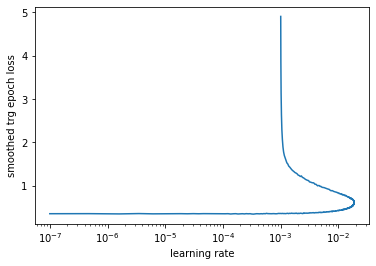

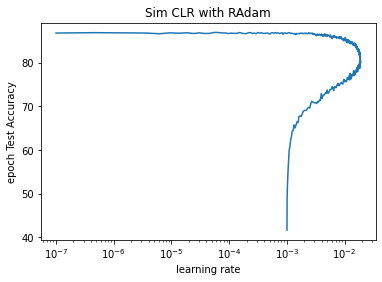

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df=pd.read_csv(csvfilename)

f1=plt.figure()
plt.semilogx(df['lr_epoch'],df['smooth_loss'])  
plt.xlabel('learning rate')
plt.ylabel('smoothed trg epoch loss')
plt.show()

f2=plt.figure()
plt.semilogx(df['lr_epoch'],df['test_acc@1'])
plt.title('Sim CLR with RAdam')
plt.xlabel('learning rate')
plt.ylabel('epoch Test Accuracy')
plt.show()